### Importing the Dataset

In [2]:
import numpy as np
import pandas as pd
import keras

posts = pd.read_csv("../data/Suicide_Detection.csv")
posts.drop(["Unnamed: 0"], axis=1, inplace=True)
posts[["class"]] = (posts[["class"]] == "suicide").astype("int16")

2024-07-08 18:20:47.805345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 18:20:47.812265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 18:20:47.822670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 18:20:47.822690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 18:20:47.829052: I tensorflow/core/platform/cpu_feature_gua

In [3]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2024-07-08 18:20:49.445628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 18:20:49.465103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 18:20:49.465195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Exploring the Dataset

In [4]:
posts.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [5]:
posts.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [6]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.2, random_state=42)

#### Analyzing the Dataset

In [7]:
posts = strat_train_set.copy()
posts.head()

,text,class
103752,I am going to kill myself soonI don't know whe...,1
208014,Using this sub as a diary day 68 Today was gre...,0
220765,What else are you supposed to do?I've got a se...,1
116840,Hey you. Yes you I need your help to get this ...,0
149067,non trans gender dysphoria be like menstruatio...,0


In [8]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [9]:
post_lengths[:10]

[98, 58, 273, 54, 109, 10, 166, 103, 43, 190]

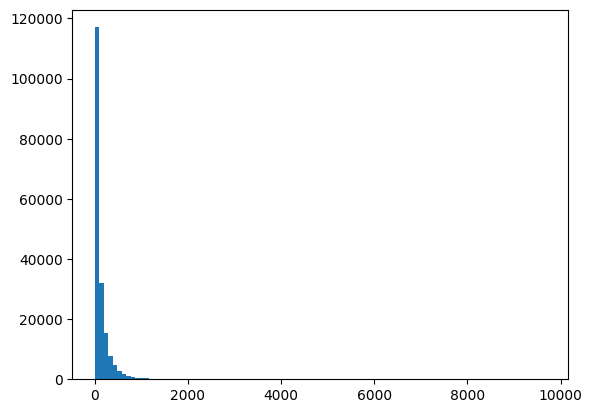

In [10]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

#### Spliting the dataset (again)

In [16]:
texts = posts.copy()['text'][:150000]
labels = posts.copy()['class'][:150000]
texts[:5], labels[:5]

(103752    I am going to kill myself soonI don't know whe...
 208014    Using this sub as a diary day 68 Today was gre...
 220765    What else are you supposed to do?I've got a se...
 116840    Hey you. Yes you I need your help to get this ...
 149067    non trans gender dysphoria be like menstruatio...
 Name: text, dtype: object,
 103752    1
 208014    0
 220765    1
 116840    0
 149067    0
 Name: class, dtype: int16)

#### Tokenizing the posts

In [17]:
import spacy
spacy.prefer_gpu()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [18]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [19]:
len(texts)

150000

In [20]:
docs = list(nlp.pipe(texts))

OutOfMemoryError: Out of memory allocating 52,615,680 bytes (allocated so far: 11,544,960,000 bytes).

In [ ]:
processed_texts = []
for doc in docs:
    lemmas = [token.lemma_ for token in doc]
    processed_texts.append(' '.join(lemmas))

In [ ]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=3000, oov_token='<UNK>')
tokenizer.fit_on_texts(processed_texts)

In [ ]:
# from keras.layers import TextVectorization

# vectorizer = TextVectorization(max_tokens=100, output_mode='count', sparse=True)
# vectorizer.adapt(processed_texts)

In [ ]:
sequences = tokenizer.texts_to_sequences(processed_texts)

In [ ]:
sequence_lengths = [len(sequence) for sequence in sequences if len(sequence) < 1000]

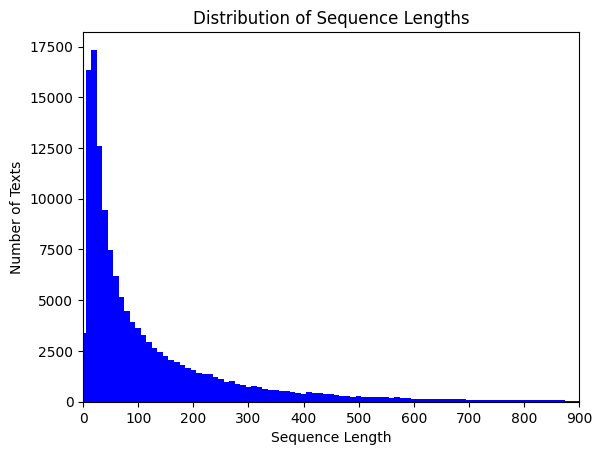

In [ ]:
plt.hist(sequence_lengths, bins=100, color='blue', align='left')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Texts')
plt.title('Distribution of Sequence Lengths')
plt.xlim(0, 200)
plt.xticks(range(0, max(sequence_lengths) + 1, 100))
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, processed_texts)
train_labels = np.array(labels)

In [ ]:
word_index = tokenizer.word_index

sorted(word_index.items(), key=lambda x: x[1])[:10]

[('<UNK>', 1),
 ('i', 2),
 ('be', 3),
 ('to', 4),
 ('and', 5),
 ('the', 6),
 ('not', 7),
 ('a', 8),
 ('my', 9),
 ('do', 10)]

#### Creating the model

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('strat_train_set', 135788791),
 ('texts', 135510303),
 ('strat_val_set', 45058668),
 ('strat_test_set', 44984403),
 ('val_texts', 44965838),
 ('post_lengths', 1624056),
 ('labels', 1392472),
 ('docs', 1140568),
 ('processed_texts', 1140568),
 ('val_labels', 464182),
 ('lemmas', 7832),
 ('Tokenizer', 1704),
 ('doc', 184),
 ('open', 160),
 ('train_test_split', 160),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('tf', 72),
 ('nlp', 48),
 ('tokenizer', 48)]

In [ ]:
Sequential = keras.models.Sequential

model = Sequential([
        keras.layers.Embedding(1000, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
padded_train_seq

array([[   2,   61,  334, ...,    0,    0,    0],
       [   2,  282,  333, ...,    2,    3,   20],
       [   9,  743,    3, ...,    0,    0,    0],
       ...,
       [ 223,  182,   15, ...,    0,    0,    0],
       [   7,  213,   40, ...,   25,  122,   12],
       [   7,  235,    4, ...,   57, 1004,   33]], dtype=int32)

In [ ]:
del val_texts

In [ ]:
val_docs = list(nlp.pipe(val_texts))

NameError: name 'val_texts' is not defined

In [ ]:
processed_val_texts = []
for doc in val_docs:
    lemmas = [token.lemma_ for token in doc]
    processed_val_texts.append(' '.join(lemmas))

OutOfMemoryError: Out of memory allocating 89,630,208 bytes (allocated so far: 11,472,828,928 bytes).

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

val_seq = get_sequences(tokenizer, processed_val_texts)
val_labels = np.array(val_labels)


h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

### Evaluating the Model

In [ ]:
model.summary()

In [ ]:
test_texts = strat_test_set.copy()['text']
test_labels = strat_test_set.copy()['class']

test_seq = get_sequences(tokenizer, test_texts)
test_labels = np.array(test_labels)

In [ ]:
test_seq, test_labels

In [ ]:
_ = model.evaluate(test_seq, test_labels)

In [ ]:
y_pred = model.predict(test_seq)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[1], y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()